# Neural Network Classifier with Mini-Batch Gradient Descent

#### Author: Ivan Bongiorni, Data Scientist at GfK.

[LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/)

This model is a **feed forward Neural Network Classifier** based on the classical **spam dataset**.

It represents a tutorial on basic TensorFlow 2.0 (alpha). The 1.x version of the same model can be found in [this Notebook](https://github.com/IvanBongiorni/TensorFlow_Tutorial/blob/master/TensorFlow_2_Classification_MiniBatchGD.ipynb).

Summary:

0. Why Mini-Batch Gradient Descent?
1. Import data + dataprep,
2. Neural Network architecture,
3. Implementation of full-Batch Gradient Descent,
4. Visualization

## 0. Why Mini-Batch Gradient Descent?

**Mini-Batch Gradient Descent** is of fundamental importance for Deep Learning.

It consists in feeding, at each iteration of the Gradient Descent, only a subset of (i.e.: a mini-batch) of the training data. At each iteration, mini-batch gradient descent will take a different mini-batch of data, and train just on that one.

This technique presents at least three advantages:

- It prevents the optimization algorithm to end up stuck into some local optima of the loss function.
- It allows for a significant drop in computational times. That is because the optimizer trains the network just on a mini-batch of data, requiring much less effort. Often Data Scientists are dealing with massive amounts of data, and training a model on the whole train dataset at each epoch might simply be impossible.
- It is the mandatory technique for [online learning](https://en.wikipedia.org/wiki/Online_machine_learning).

In [1]:
import tensorflow as tf

print(tf.__version__)

2.0.0-alpha0


In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None  # this prints all columns

from matplotlib import pyplot as plt

## 1. Import data + dataprep

The **spam classification dataset**, [available from the UCI ML repository](https://archive.ics.uci.edu/ml/datasets/spambase) contains an already preprocessed collection of email data. Each datapoint corresponds to an email, and is classified as either "spam" or "not spam".

In [3]:
# load the data directly from the repository into pandas

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data")
df.shape

(4600, 58)

In [4]:
df.head()

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,0.7,0.64.2,0.8,0.9,0.10,0.32.1,0.11,1.29,1.93,0.12,0.96,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32.2,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.778,0.43,0.44,3.756,61,278,1
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


In [5]:
df.describe()

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,0.7,0.64.2,0.8,0.9,0.10,0.32.1,0.11,1.29,1.93,0.12,0.96,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32.2,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.778,0.43,0.44,3.756,61,278,1
count,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,0.104576,0.212922,0.280578,0.065439,0.312222,0.095922,0.114233,0.105317,0.090087,0.239465,0.059837,0.541680,0.093950,0.058639,0.049215,0.248833,0.142617,0.184504,1.662041,0.085596,0.809728,0.121228,0.101667,0.094289,0.549624,0.265441,0.767472,0.124872,0.098937,0.102874,0.064767,0.047059,0.097250,0.047846,0.105435,0.097498,0.136983,0.013204,0.078646,0.064848,0.043676,0.132367,0.046109,0.079213,0.301289,0.179863,0.005446,0.031876,0.038583,0.139061,0.016980,0.268960,0.075827,0.044248,5.191827,52.170870,283.290435,0.393913
std,0.305387,1.290700,0.504170,1.395303,0.672586,0.273850,0.391480,0.401112,0.278643,0.644816,0.201565,0.861791,0.301065,0.335219,0.258871,0.825881,0.444099,0.530930,1.775669,0.509821,1.200938,1.025866,0.350321,0.442681,1.671511,0.887043,3.367639,0.538631,0.593389,0.456729,0.403435,0.328594,0.555966,0.329480,0.532315,0.402664,0.423493,0.220675,0.434718,0.349953,0.361243,0.766900,0.223835,0.622042,1.011787,0.911214,0.076283,0.285765,0.243497,0.270377,0.109406,0.815726,0.245906,0.429388,31.732891,194.912453,606.413764,0.488669
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.310000,0.000000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.275500,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.382500,0.000000,0.000000,0.000000,0.000000,0.160000,0.000000,0.800000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,2.640000,0.000000,1.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

### Explore the target variable

Let's explore the dependent variable. Before feeding the data in a Neural Network, it will require one-hot encoding.

In [6]:
# Description of the classification variable
df.iloc[:,57].describe()

count    4600.000000
mean        0.393913
std         0.488669
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: 1, dtype: float64

In [7]:
print(set(df.iloc[:,57]))
print('no. classes: ' + str(len(set(df[df.columns[1]]))))

{0, 1}
no. classes: 171


In [8]:
# One-hot encoding

classification = pd.get_dummies(df.iloc[:,57])
print(classification.shape)

(4600, 2)


I obtained a target dataframe, called `classification`, that contains the one-hot encoded version of my dependent binary variable. Now I can isolate the explanatory variables in my dataframe `df`. In order to do that I'll drop columns 0 and 1: the first is an index, the second is the target variable. 

In [9]:
df = df.drop(df.columns[57], axis=1)   # drop target column from explanatory df

In [10]:
# Now the shape is:
df.shape

(4600, 57)

Before training the model, I turn both explanatory and target data into numpy objects:

In [11]:
df = df.values.astype(np.float64)
classification = classification.values.astype(np.float64)

### Train-Test split

In an actual ML job, you would split your dataset in **Train**, **Validation** and **Test** sets. However, this is just an example on how to implement and run a Neural Network, so I'll skip that part and will split the data in train and test only.

In [12]:
## TRAIN-TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, classification, test_size=0.25, random_state=173)

print('X_train shape: ' + str(X_train.shape) + '\ny_train shape: ' + str(y_train.shape))
print('\nX_test shape: ' + str(X_test.shape) + '\ny_test shape: ' + str(y_test.shape))

X_train shape: (3450, 57)
y_train shape: (3450, 2)

X_test shape: (1150, 57)
y_test shape: (1150, 2)


Scaling the variables must happen after the train-test split. That is because the test set must be scaled using the parameters of the training set: in real world cases you don't know what data you'll get from training, therefore this is the only way to truly understand the performance of the model.

In [13]:
# Scale the variables using Z-scores
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 2. Neural Network architecture

Since the network is not very deep, and the number of parameters is relatively small, I can employ more "demanding" (and performing) activation functions. In this case, I chose **ELU** (**Exponential Linear Unit**) activations. A **softmax** function is then applied at the end, so that the attribution of classes ("spam"/"not-spam") is shrinked into probabilities.

Additionally, I apply **dropout** in order to prevent overfitting. 

In [14]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.activations import elu, softmax

# Architecture
n_input = X_train.shape[1]
n_hidden1 = 30
n_hidden2 = 30
n_hidden3 = 15
n_output = y_train.shape[1]

# set dropout probability
dropout_prob = 0.1


The definition of a model in TensorFlow 2.0 follows the syntax of Keras' `Sequential()` models.

Each layer is defined by the `Dense()` function, taking as inputs: the previous layer, the number of nodes, and the activation function (it can actually take a lor of additional arguments, but I'll not review them here). The input layer also requires a definition of the input data shape.

In [15]:
model = tf.keras.models.Sequential([
    Dense(n_input, input_shape = (n_input,), activation = elu),   # Input layer
    
    Dense(n_hidden1, activation = elu), # hidden layer 1
    Dropout(dropout_prob), 
    
    Dense(n_hidden2, activation = elu), # hidden layer 2
    Dropout(dropout_prob), 
    
    Dense(n_hidden3, activation = elu), # hidden layer 3
    Dropout(dropout_prob), 
    
    Dense(n_output, activation = softmax)  # Output layer
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 57)                3306      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1740      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0

## 3. Implementation of Mini-Batch Gradient Descent

In order to feed mini-batches of data into the Network at each iteration, I will write a function that takes a different subset of the main dataset at each epoch.

In [17]:
@tf.function
def fetch_batch(X, y, batch_size, epoch):
    '''
    Extracts a mini-batches of given size from a dataset.
    WARNING: Requires a batch size that is multiple of the number of training epochs
    
    Returns: Train and Test Mini-Batches
    '''
    start = epoch*batch_size  # starting row of next mini-batch
        
    X_batch = X[start:start+batch_size, :]
    y_batch = y[start:start+batch_size, :]
    
    return X_batch, y_batch

### On the @tf.function decorator

It's worth to spend few words on the **decorator @tf.function**. The decorator transform plain Python functions into TensorFlow's **graph code** (yeah, the underlying TensorFlow code is still in graph mode as in 1.x, you just can't see it now). This has the advantage to make it compatible with the module's functinos, and the make their runtime much faster.


Now I'll define the usual hyperparameters of the model:

In [18]:
# Loss: Binary cross-entropy is specific for binary classification tasks
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Binary Accuracy (expressed in the [0,1] interval)
accuracy = tf.keras.metrics.BinaryAccuracy()

# Adam Optimizer (what you'll need 99.99% of the time)
optimizer = tf.optimizers.Adam(learning_rate = 0.0005)

As [in the previous Notebook](https://github.com/IvanBongiorni/TensorFlow2.0_Tutorial/blob/master/TensorFlow2.0_01_basic_Classifier.ipynb), I'll use TensorFlow's **eager execution method**. Please refer to it for a more detailed explanation.

The fundamental element of training a Network in eager execution is represented by `tf.GradientTape()`. This object calculates and stores the gradient of the loss function at each iteration of the training operation. Once you generate a GradientTape, you can call the `.gradient()` argument to get the actual gradient (i.e. the first derivative of the loss function). Later, you feed this values into an `optimizer` using the `.apply_gradients` argument that updates the Network's trainable variables (the very act of "learning").

In [19]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=173)

In [31]:
batch_size = 40

n_epochs = len(X_train) // batch_size

print('No. of epochs: ' + str(n_epochs))

No. of epochs: 86


In [21]:
###  TRAINING

loss_history = []
accuracy_history = []


# I set a number of epochs that correspond to the number of mini-batches
for epoch in range(n_epochs):
    
    # load the Mini-Batches
    X_batch, y_batch = fetch_batch(X_train, y_train, batch_size, epoch)
    
    with tf.GradientTape() as tape:
        current_loss = bce_loss(model(X_batch), y_batch)  # take current loss
    
    gradients = tape.gradient(current_loss, model.trainable_variables)    # get the gradient of the loss function
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # update the weights
    
    loss_history.append(current_loss.numpy())   # save current loss in its history vector
    
    accuracy.update_state(y_batch, model(X_batch))  # compute current accuracy
    current_accuracy = accuracy.result().numpy()  # save its result as numpy object
    accuracy_history.append(current_accuracy)
    
    # To monitor progress, print loss and accuracy scores every 10 epochs
    if (epoch+1) % 10 == 0:
        print(str(epoch+1) + '.\tTraining Loss: ' + str(current_loss.numpy()) + ',\tAccuracy: ' + str(current_accuracy))
    
    accuracy.reset_states()  # reset the state of accuracy object for next iteration
#
print('\nTraining complete.')


10.	Training Loss: 6.2499895095825195,	Accuracy: 0.725
20.	Training Loss: 4.657613277435303,	Accuracy: 0.825
30.	Training Loss: 3.2141194343566895,	Accuracy: 0.875
40.	Training Loss: 3.3126113414764404,	Accuracy: 0.85
50.	Training Loss: 1.7333042621612549,	Accuracy: 0.925
60.	Training Loss: 1.866158127784729,	Accuracy: 0.925
70.	Training Loss: 2.6816811561584473,	Accuracy: 0.875
80.	Training Loss: 1.3021173477172852,	Accuracy: 0.95

Training complete.


## 4. Visualization

Once the training is done, let's check the model's improvement visually:

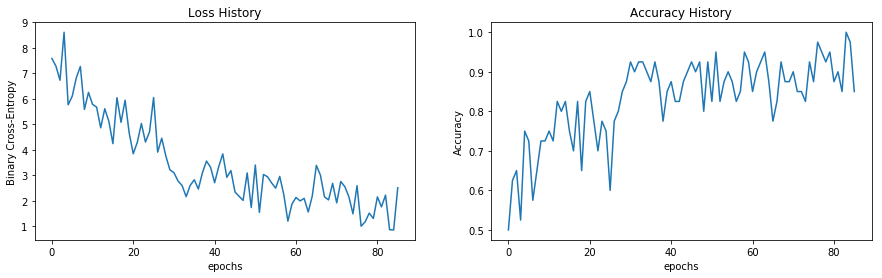

In [22]:
# using plt.subplot I can show paired loss and accuracy

plt.figure(figsize = (15, 4))  # adjust figures size
plt.subplots_adjust(wspace=0.2)  # adjust distance

# loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('epochs')
plt.ylabel('Binary Cross-Entropy')

# accuracy plot
plt.subplot(1, 2, 2)
plt.plot(accuracy_history)
plt.title('Accuracy History')
plt.xlabel('epochs')
plt.ylabel('Accuracy')

plt.show()

As you can see, the main difference from full-Batch Gradient Descent is that the loss and accuracy histories look much more noisy. This was predictable, since at each iteration the model is trained only on a very small amount of data.

At this point, Let's make a prediction on the test set.

In [23]:
prediction = model.predict(X_test)    # (Keras syntax)

In [24]:
# outputs a vector that contains the value of the class with the highest predicted probability
prediction = np.argmax(prediction, axis=1)

# so I do it also for the test data - i.e.: reverse one-hot encoding and get a vector of 0-1 values
testdata = np.argmax(y_test, axis=1)


In [25]:
# Now I can plot the Confusion Matrix
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(prediction, testdata)
print(CM)

[[673  69]
 [ 32 376]]


The Confusion Matrix looks very good: oservations on the matrix diagonal are correct predictions. Luckily, only two datapoints have been misclassified.

In [26]:
# Accuracy = sum of the diagonal / sum of the whole matrix

print('Test Accuracy: ' + str(np.sum(np.diag(CM)) / np.sum(CM)))

Test Accuracy: 0.9121739130434783


I like to visualize Confusion Matrices using a heatmap. IMHO, `seaborn` is the best Python library for that:

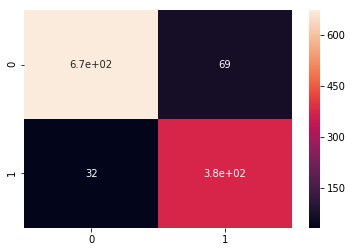

In [30]:
import seaborn

seaborn.heatmap(CM, annot=True)
plt.show()

OK, this was Mini-Batch Gradient Descent. In real world problems, you'll find this optimization techniques to be computationally much faster than full-Batch Gradient Descent.

Most importantly, you'll likely achieve faster convergence of your Gradient. Even if full-Batch optimization can better approach the global minimum of your loss function, it might take eons to converge.
That's why you often find Mini-Batch version of your optimization algorithm to achieve higher performances than its full-Batch counterpart (on a reasonable amount of training epochs).